Epoch 0: Loss 309400128.0
Epoch 100: Loss 12274874.0
Epoch 200: Loss 4890500.0
Epoch 300: Loss 3528199.75
Epoch 400: Loss 2937282.75
Epoch 500: Loss 2578059.75
Epoch 600: Loss 2325767.5
Epoch 700: Loss 2129583.75
Epoch 800: Loss 1974732.125
Epoch 900: Loss 1845229.75


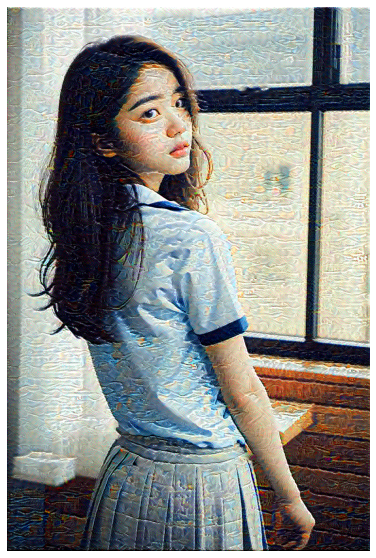

FileNotFoundError: [Errno 2] No such file or directory: 'output/generated_image.jpg'

In [10]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
dir = os.getcwd()
content_path = dir + '/content_image.jpg'
style_path = dir + '/style_image_van.jpg'

def load_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

content_image = load_image(content_path)
style_image = load_image(style_path)

def vgg_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
    return model

content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

# Create the model
model = vgg_model(style_layers + content_layers)
def content_loss(generated_features, content_features):
    return tf.reduce_mean(tf.square(generated_features - content_features))

def gram_matrix(tensor):
    reshaped_tensor = tf.reshape(tensor, (-1, tensor.shape[-1]))
    gram = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    return gram

def style_loss(generated_features, style_features):
    gram_generated = gram_matrix(generated_features)
    gram_style = gram_matrix(style_features)
    return tf.reduce_mean(tf.square(gram_generated - gram_style))

def optimize_generated_image(content_image, style_image, epochs=1000, alpha=1.0, beta=1e-4):
    generated_image = tf.Variable(content_image, dtype=tf.float32)

    # Obtain content and style features
    content_output = np.array(model(content_image)[:-len(style_layers)])
    style_output = model(style_image)[-len(style_layers):]

    for e in range(epochs):
        with tf.GradientTape() as tape:
            outputs = model(generated_image)
            content_features = outputs[:-len(style_layers)]
            style_features = outputs[-len(style_layers):]

            # Compute total loss
            content_losses = [content_loss(content_features[i], content_output[i]) for i in range(len(content_layers))]
            style_losses = [style_loss(style_features[i], style_output[i]) for i in range(len(style_layers))]
            loss = alpha * sum(content_losses) + beta * sum(style_losses)

        # Compute gradients and update the generated image
        gradients = tape.gradient(loss, generated_image)
        tf.optimizers.Adam().apply_gradients([(gradients, generated_image)])
        
        if e % 100 == 0:
            print(f"Epoch {e}: Loss {loss.numpy()}")

    return tf.clip_by_value(generated_image, 0.0, 1.0).numpy()

generated_image = optimize_generated_image(content_image, style_image, epochs=1000, alpha=1.0, beta=1e-4)

# Visualize the generated image
plt.figure(figsize=(10, 10))
plt.imshow(generated_image[0])
plt.axis('off')
plt.show()

# Save the generated image
generated_image = np.squeeze(generated_image) * 255
generated_image = Image.fromarray(np.uint8(generated_image))
generated_image.save(dir + '/generated_image.jpg')
